### Connect to WRDS

In [1]:
import wrds
db = wrds.Connection()

Enter your WRDS username [shanc]:shanali88
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


# Testing

### Classification Table

In [2]:
sql_query = """
-- Summary Table
SELECT
    crsp_q_mutualfunds.fund_style.CRSP_FUNDNO,
    crsp_q_mutualfunds.fund_style.BEGDT,
    crsp_q_mutualfunds.fund_style.ENDDT,
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS
FROM 
    crsp_q_mutualfunds.fund_style
WHERE
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS = 'SCVE'
LIMIT 10
"""
data_query = db.raw_sql(sql_query)
data_query.head()

,crsp_fundno,begdt,enddt,lipper_class
0,292.0,1999-12-31,2000-08-31,SCVE
1,479.0,1999-12-31,2000-12-30,SCVE
2,657.0,1999-12-31,2000-02-29,SCVE
3,671.0,1999-12-31,2000-06-30,SCVE
4,709.0,1999-12-31,2000-01-31,SCVE


### Monthly Return Data

In [3]:
sql_query = """
-- Return Table
SELECT
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_returns.CALDT,
    crsp_q_mutualfunds.monthly_returns.MRET
FROM 
    crsp_q_mutualfunds.monthly_returns
LIMIT 10
"""
data_query = db.raw_sql(sql_query)
data_query.head()

,crsp_fundno,caldt,mret
0,1.0,1997-02-28,NaN
1,1.0,1997-03-31,-0.011789
2,1.0,1997-04-30,0.008417
3,1.0,1997-05-30,0.013523
4,1.0,1997-06-30,0.012502


### Monthly TNA Table

In [4]:
sql_query = """
-- TNA Table
SELECT
    crsp_q_mutualfunds.monthly_tna.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_tna.CALDT,
    crsp_q_mutualfunds.monthly_tna.MTNA
FROM 
    crsp_q_mutualfunds.monthly_tna
LIMIT 10
"""
data_query = db.raw_sql(sql_query)
data_query.head()

,crsp_fundno,caldt,mtna
0,1.0,1997-01-31,0.100
1,1.0,1997-02-28,3.926
2,1.0,1997-03-31,12.081
3,1.0,1997-04-30,20.540
4,1.0,1997-05-30,26.157


# Assignment

### Monthly Return vs Monthly TNA

In [2]:
sql_query = """
SELECT
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_returns.CALDT,
    crsp_q_mutualfunds.monthly_returns.MRET,
    crsp_q_mutualfunds.monthly_tna.MTNA
FROM 
    crsp_q_mutualfunds.monthly_returns
INNER JOIN
    crsp_q_mutualfunds.monthly_tna
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.monthly_tna.CRSP_FUNDNO
INNER JOIN
    crsp_q_mutualfunds.fund_style
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.fund_style.CRSP_FUNDNO
WHERE
    crsp_q_mutualfunds.fund_style.BEGDT <= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.fund_style.ENDDT >= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.monthly_returns.CALDT = crsp_q_mutualfunds.monthly_tna.CALDT AND
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS = 'SCVE'
ORDER BY
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_returns.CALDT
"""

data_query = db.raw_sql(sql_query)

### Regression

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Drop NAs
data_queryClean = data_query.dropna(axis=0)
reg = LinearRegression().fit(np.array(data_queryClean['mtna'].values).reshape(-1,1), 
                             np.array(data_queryClean['mret'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])

Coefficient:  3.536619990658294e-07
Intercept:  0.007310037137654173


### Plotting

<function matplotlib.pyplot.show(*args, **kw)>

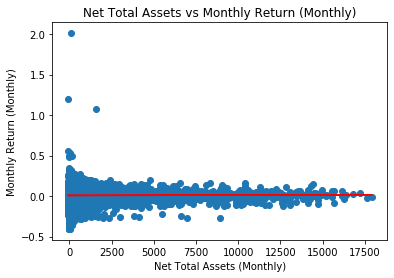

In [4]:
import matplotlib.pyplot as plt

plt.scatter(data_queryClean['mtna'], data_queryClean['mret'])
plt.plot(data_queryClean['mtna'],reg.predict(np.array(data_queryClean['mtna'].values).reshape(-1,1)), color='red')
plt.xlabel('Net Total Assets (Monthly)')
plt.ylabel('Monthly Return (Monthly)')
plt.title('Net Total Assets vs Monthly Return (Monthly)')
plt.show

### Monthly Risk

Coefficient:  -1.7913752542336768e-06
Intercept:  0.05981240157476869
R-squared:  0.0018698032394877104


<function matplotlib.pyplot.show(*args, **kw)>

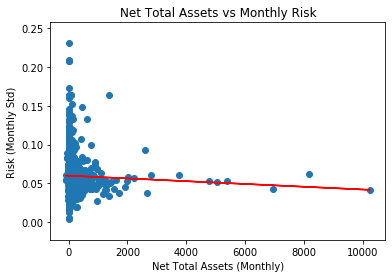

In [32]:
# get std
mstd = data_query.groupby(['crsp_fundno']).agg({'mret':'std','mtna':'mean'})

# Drop NAs
mstd = mstd.dropna(axis=0)
reg = LinearRegression().fit(np.array(mstd['mtna'].values).reshape(-1,1), 
                             np.array(mstd['mret'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])
print('R-squared: ', reg.score(np.array(mstd['mtna'].values).reshape(-1,1), 
                             np.array(mstd['mret'].values).reshape(-1,1)))

# plot
plt.scatter(mstd['mtna'], mstd['mret'])
plt.plot(mstd['mtna'],reg.predict(np.array(mstd['mtna'].values).reshape(-1,1)), color='red')
plt.xlabel('Net Total Assets (Monthly)')
plt.ylabel('Risk (Monthly Std)')
plt.title('Net Total Assets vs Monthly Risk')
plt.show

### Annualzed Returns vs Average TNA

In [26]:
sql_query = """
SELECT
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    AVG(crsp_q_mutualfunds.monthly_returns.MRET) AS AVG_MRET,
    AVG(crsp_q_mutualfunds.monthly_tna.MTNA) AS AVG_MNTA
FROM 
    crsp_q_mutualfunds.monthly_returns
INNER JOIN
    crsp_q_mutualfunds.monthly_tna
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.monthly_tna.CRSP_FUNDNO
INNER JOIN
    crsp_q_mutualfunds.fund_style
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.fund_style.CRSP_FUNDNO
WHERE
    crsp_q_mutualfunds.fund_style.BEGDT <= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.fund_style.ENDDT >= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.monthly_returns.CALDT = crsp_q_mutualfunds.monthly_tna.CALDT AND
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS = 'SCVE'
GROUP BY
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO
    
"""

data_query = db.raw_sql(sql_query)

# Annualize Returns
data_query['annualReturn'] = (1+data_query['avg_mret'])**12 - 1

### Regression

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Drop NAs
data_queryClean = data_query.dropna(axis=0)
reg = LinearRegression().fit(np.array(data_queryClean['avg_mnta'].values).reshape(-1,1), 
                             np.array(data_queryClean['annualReturn'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])


Coefficient:  -3.3230317766322066e-06
Intercept:  0.12313431155469776


### Plotting

<function matplotlib.pyplot.show(*args, **kw)>

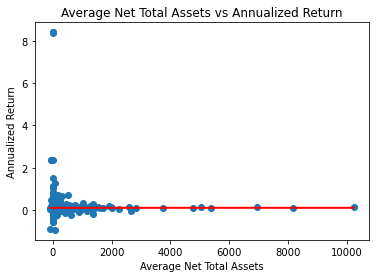

In [28]:
import matplotlib.pyplot as plt

plt.scatter(data_queryClean['avg_mnta'], data_queryClean['annualReturn'])
plt.plot(data_queryClean['avg_mnta'],reg.predict(np.array(data_queryClean['avg_mnta'].values).reshape(-1,1)), color='red')
plt.xlabel('Average Net Total Assets')
plt.ylabel('Annualized Return')
plt.title('Average Net Total Assets vs Annualized Return')
plt.show

### Annual Risk

Coefficient:  -6.205505911508683e-06
Intercept:  0.2071962369004242
R-squared:  0.0018698032394874886


<function matplotlib.pyplot.show(*args, **kw)>

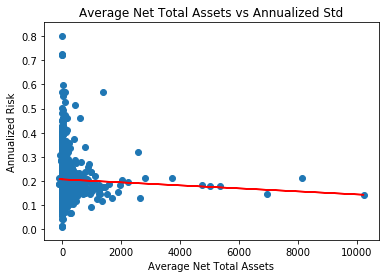

In [33]:
# annualize std
astd = mstd.copy()
astd['astd'] = astd['mret']*np.sqrt(12)

# Drop NAs
astd = astd.dropna(axis=0)
reg = LinearRegression().fit(np.array(astd['mtna'].values).reshape(-1,1), 
                             np.array(astd['astd'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])
print('R-squared: ', reg.score(np.array(astd['mtna'].values).reshape(-1,1), 
                             np.array(astd['astd'].values).reshape(-1,1)))

# plot
plt.scatter(astd['mtna'], astd['astd'])
plt.plot(astd['mtna'],reg.predict(np.array(astd['mtna'].values).reshape(-1,1)), color='red')
plt.xlabel('Average Net Total Assets')
plt.ylabel('Annualized Risk')
plt.title('Average Net Total Assets vs Annualized Std')
plt.show